# Part 2b: Spatial Autocorrelation of Grocery Store Locations by Ward
This notebook continues to analyzing existing food landscapes. The following data, plots, and maps help us determine whether there is a geo-statistically significant relationship between grocery store placement within Wards. In previous notebooks, we found that race/ethnicity and income is spatially and disproportionately concentrated by Ward; through this analysis, we will look to see if there is a validated relationship between food resources and Ward. Data sources include:

* [Open Data DC: Wards from 2022](https://opendata.dc.gov/datasets/DCGIS::wards-from-2022/about)
* [Open Data DC: Grocery Store Locations 2022](https://opendata.dc.gov/datasets/DCGIS::grocery-store-locations/about)

Let's begin by importing the relevant libraries for data exploration and analysis.

In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import contextily as ctx
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px

## Ward Geography
Our first step is to import geographic boundaries. We'll be using Ward boundaries for the City of Washington DC, sourced from Open Data DC. We are looking at the Ward level because this is where the most political and community-based alignment and scale lies, making it a relevant and effective spatial scale to use. Since most of the available data also incorporates Ward scale, it will make sense to establish this as our geographic boundary.

In [2]:
# import geography
gdf_wards = gpd.read_file('Wards_from_2012.geojson')

In [3]:
# data cleanup
gdf_wards.info(verbose=True, show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 86 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   OBJECTID                   8 non-null      int64   
 1   WARD                       8 non-null      int64   
 2   NAME                       8 non-null      object  
 3   REP_NAME                   8 non-null      object  
 4   WEB_URL                    8 non-null      object  
 5   REP_PHONE                  8 non-null      object  
 6   REP_EMAIL                  8 non-null      object  
 7   REP_OFFICE                 8 non-null      object  
 8   WARD_ID                    8 non-null      object  
 9   LABEL                      8 non-null      object  
 10  AREASQMI                   8 non-null      float64 
 11  POP_2000                   8 non-null      int64   
 12  POP_2010                   8 non-null      int64   
 13  POP_2011_2015              8 no

Using the available data dictionary, we'll want to grab the following columns: WARD (representing Wards 1-8), P0010001 (representing the total population count, which will help us when attempting to normalize the data later on), and geometry (which will allow us to plot and map the data). We'll trim the data into a useable subset, then rename the column labels to make it more visually accessible.

In [4]:
gdf_wards.head(1)

OBJECTID  WARD    NAME       REP_NAME  \
0         1     6  Ward 6  Charles Allen   

                                             WEB_URL       REP_PHONE  \
0  https://www.dccouncil.us/council/councilmember...  (202) 724-8072   

             REP_EMAIL                                  REP_OFFICE WARD_ID  \
0  callen@dccouncil.us  1350 Pennsylvania Ave, Suite 406, NW 20004       6   

    LABEL  ...  BACH_DEGREE_25_PLUS  MED_VAL_OOU  \
0  Ward 6  ...                19588       573200   

                                 GLOBALID  CREATOR CREATED EDITOR EDITED  \
0  {5D2A5470-9BA3-4C94-9A21-46B5DBFF70D4}     None    None   None   None   

  SHAPEAREA SHAPELEN                                           geometry  
0         0        0  POLYGON ((-77.01790 38.91410, -77.01801 38.914...  

[1 rows x 86 columns]

In [5]:
# rename column
gdf_wards.rename(columns={'POP_2011_2015':'Total Population'}, inplace=True)
gdf_wards.tail(1)

OBJECTID  WARD    NAME      REP_NAME  \
7         8     7  Ward 7  Vincent Gray   

                                     WEB_URL       REP_PHONE  \
7  https://dccouncil.us/council/vincent-gray  (202) 724-8068   

            REP_EMAIL                                  REP_OFFICE WARD_ID  \
7  vgray@dccouncil.us  1350 Pennsylvania Ave, Suite 406, NW 20004       7   

    LABEL  ...  BACH_DEGREE_25_PLUS  MED_VAL_OOU  \
7  Ward 7  ...                 4890       238900   

                                 GLOBALID  CREATOR CREATED EDITOR EDITED  \
7  {7663AC8A-1E74-40F1-BF58-366EFAC11C5A}     None    None   None   None   

  SHAPEAREA SHAPELEN                                           geometry  
7         0        0  POLYGON ((-76.94186 38.91854, -76.94200 38.918...  

[1 rows x 86 columns]

In [6]:
# trim for only necessary columns
gdf_wards = gdf_wards[['WARD','NAME','Total Population','geometry']]
# check last row
gdf_wards.tail(1)

WARD    NAME  Total Population  \
7     7  Ward 7             73290   

                                            geometry  
7  POLYGON ((-76.94186 38.91854, -76.94200 38.918...

Now that we have a cleaned dataset, with just the Ward number, name of ward, total population count, and geometry coordinates, let's plot the data.

In [7]:
# map the wards
# get layer into web mercator
gdf_wards = gdf_wards.to_crs(epsg=3857)

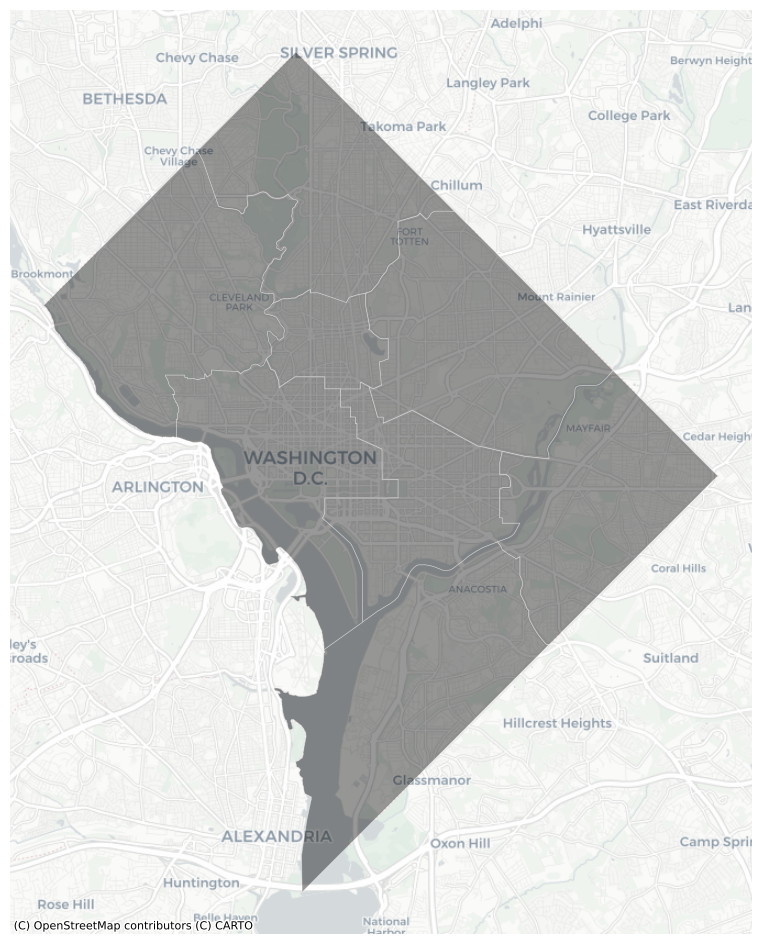

In [8]:
# plot the wards
fig, ax = plt.subplots(figsize=(12,12))
gdf_wards.plot(ax=ax,
               color='black',
               edgecolor='white',
               lw=0.5,
               alpha=0.4)
ax.axis('off')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

Now we have a workable basemap of the city of Washington DC, outlined with Ward boundaries.

## Grocery Store Data 
Next, we will import our variable data using the grocery stores location dataset from Open Data DC. We'll create a variable named 'groceries' to hold this information, then conduct some data exploration and cleaning.

In [9]:
# import grocery store data
groceries = pd.read_csv('Grocery_Store_Locations.csv')

In [10]:
groceries.head(1)

X          Y STORENAME                 ADDRESS  ZIPCODE  \
0 -77.026981  38.984455   Target   7828 GEORGIA AVENUE NW    20012   

        PHONE    WARD           SSL NOTES PRESENT90  ...     XCOORD  \
0  2028923822  Ward 4  2960    0017   NaN       NaN  ...  397662.57   

      YCOORD  MAR_ID SE_ANNO_CAD_DATA                                GLOBALID  \
0  146280.07  300512              NaN  {CE302122-4E8D-4DC7-845B-06563B993F66}   

  CREATOR                 CREATED EDITOR                  EDITED PRESENT22  
0    JLAY  2022/09/28 18:04:54+00   JLAY  2022/09/28 18:04:54+00       Yes  

[1 rows x 36 columns]

In order to map these x and y coordinates, we'll need to convert this dataframe into a geodataframe. Then, we'll need to get the data projected to web mercator and convert x/y coodinates into float datatypes before mapping.

In [11]:
# convert to geodataframe
groceries = gpd.GeoDataFrame(groceries,
                             crs='EPSG:4326',
                             geometry=gpd.points_from_xy(groceries.X, groceries.Y))

In [12]:
# project to web mercator
groceries = groceries.to_crs(epsg=3857)

In [13]:
# convert to floats
groceries.X = groceries.X.astype('float')
groceries.Y = groceries.Y.astype('float')

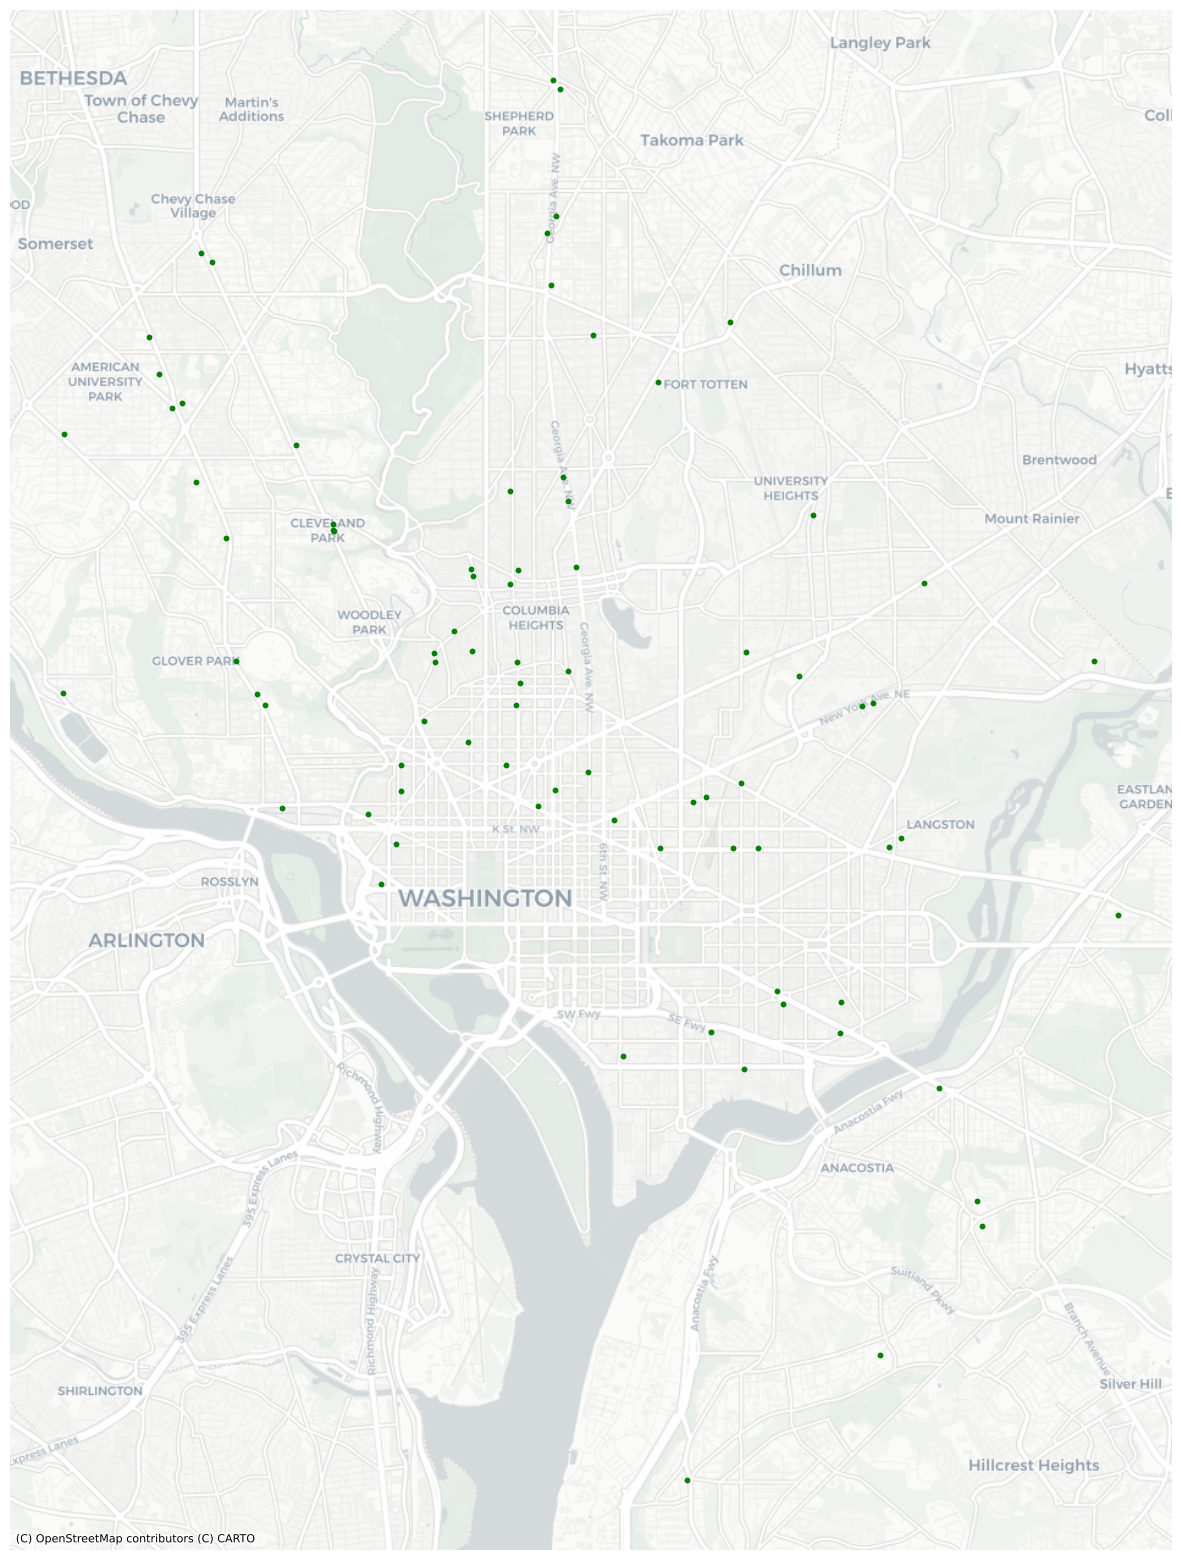

In [14]:
# map the points
fig, ax = plt. subplots(figsize=(20,20))
groceries.plot(ax=ax,
               color='green',
               markersize=10)
ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The map above shows us the spatial distribution of grocery stores across Washington DC. Just from observations, we can see that the points are more concentrated towards the center, spreading north, with fewer points distributed across the south and southeast.
## Spatial Join and Two Layer Maps

Now, we'll want to overlay our grocery store location points over the ward boundaries basemap before conducting statistical analysis. Before creating the two-layer map, we'll establish bounding coordinates for the axes.

In [15]:
# create two layer map
# get bounding box coordinates for groceries data
minx, miny, maxx, maxy = groceries.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-8582283.245991295
-8565751.753013877
4697521.828456635
4719445.172057822


To make the two-layer map, we'll use subplots and the corresponding 'ax' code to put both the ward boundaries and grocery store data on the same plot. 

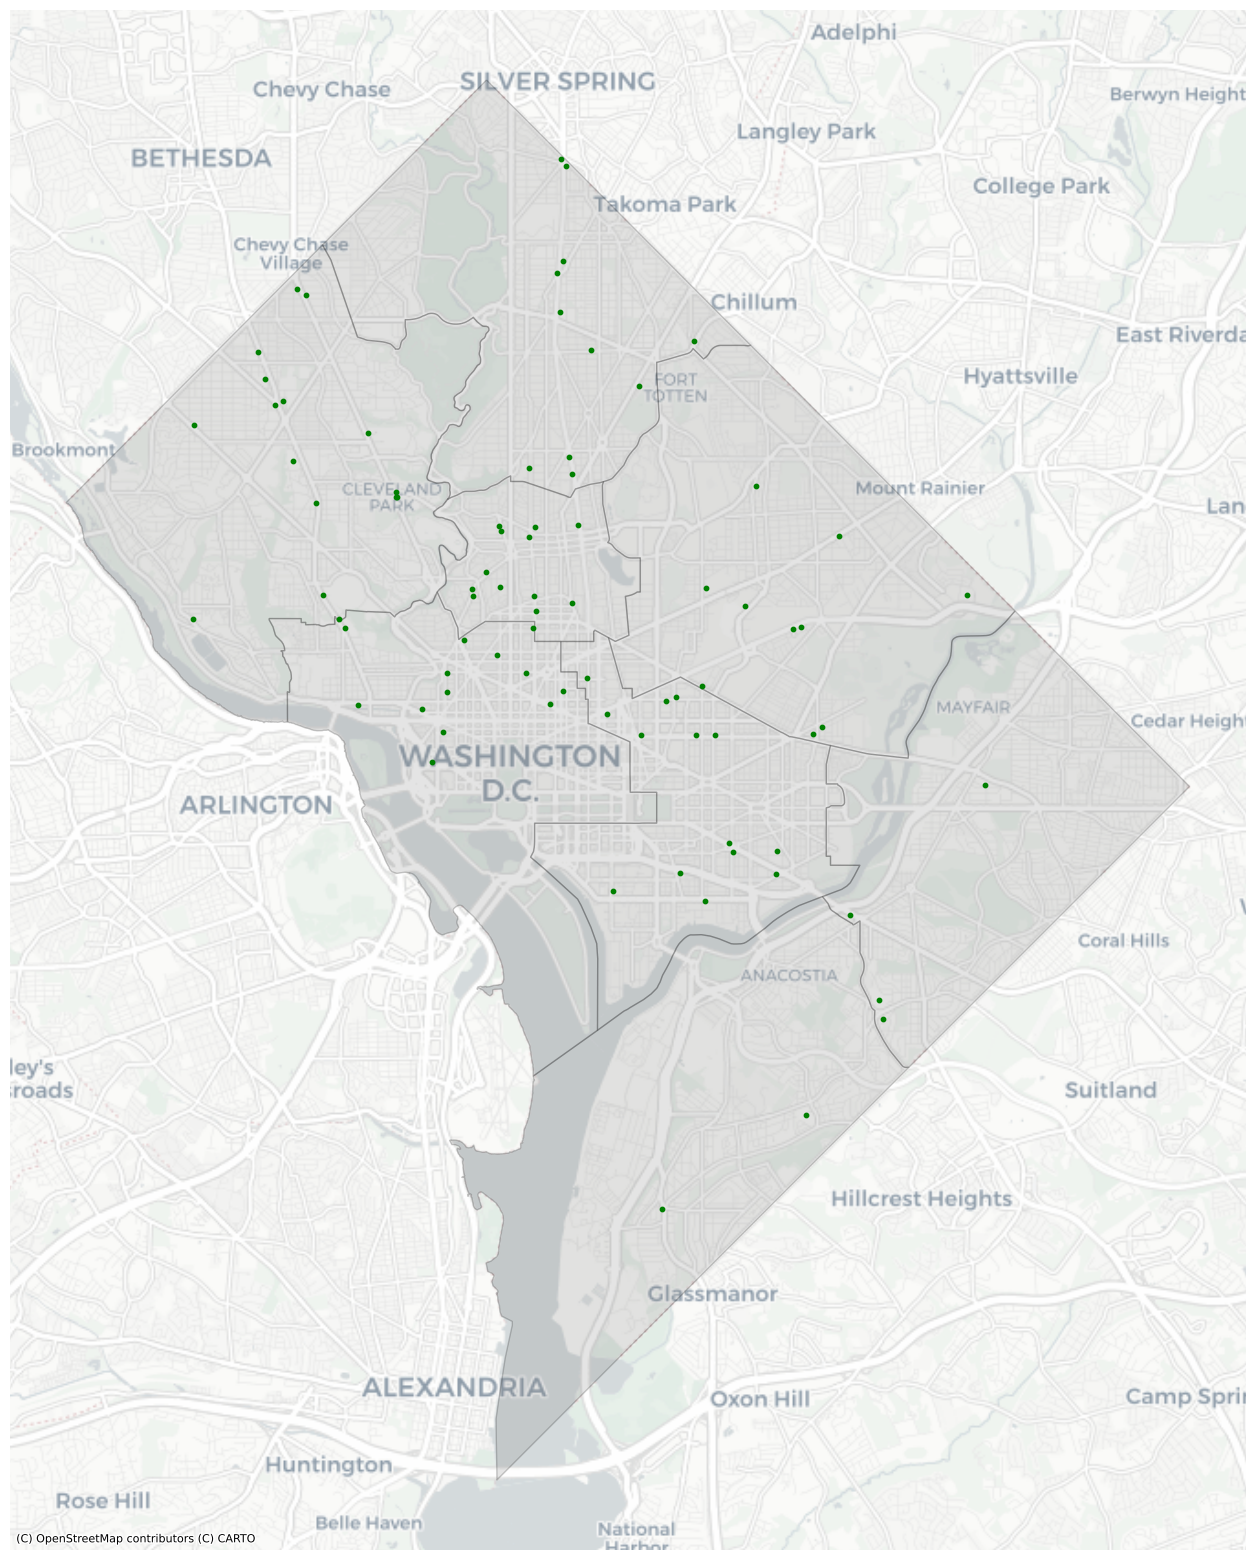

In [16]:
# create subplots for multi-layered maps
fig,ax = plt.subplots(figsize=(20,20))
# wards
gdf_wards.plot(ax=ax,
               color='gray',
               edgecolor='black',
               alpha=0.2)
# groceries
groceries.plot(ax=ax,
               color='green',
               markersize=10)

ax.axis('off')
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Great! The map plot above shows a basemap of Washington DC, overlaid with the Ward geographic boundaries, and further overlaid with point data representing different grocery store locations. It looks like most of the grocery stores are concentrated in the northern most 6 Wards, but we'll want to conduct a statistical analysis to see if there is a significant relationship between geography and groceries.

To do this, we'll start by asking how many grocery stores are there in each ward? We'll apply a count within each ward by using a spatial join. We'll use a left dataframe argument to spatially join the ward and grocery store layers, and confirm whether the join was successful by looking at the number of newly generated rows.

In [17]:
# spatial join
# check number of records
groceries.shape

(82, 37)

In [18]:
# spatial join
join = gpd.sjoin(gdf_wards, groceries, how='left')

In [19]:
# check records to see groceries with corresonding ward
join.shape

(82, 41)

Three more rows were added after the spatial join, so we know this new dataframe has every grocery store location per associated Ward number. We'll now generate another dataframe that counts groceries per Ward, and merge it back to the geodataframe for mapping by Ward.

In [20]:
# create new dataframe to count groceries by ward
groceries_by_ward = join.WARD_left.value_counts().rename_axis('WARD').reset_index(name='groceries_count')
groceries_by_ward

WARD  groceries_count
0     3               16
1     6               14
2     2               13
3     1               12
4     4               11
5     5               10
6     7                4
7     8                2

In [21]:
# join summary back to gdf
gdf_wards=gdf_wards.merge(groceries_by_ward, on='WARD')

In [22]:
gdf_wards.sample(5)

WARD    NAME  Total Population  \
5     1  Ward 1             82859   
3     3  Ward 3             83152   
7     7  Ward 7             73290   
0     6  Ward 6             84290   
1     8  Ward 8             81133   

                                            geometry  groceries_count  
5  POLYGON ((-8575522.893 4712713.561, -8575574.5...               12  
3  POLYGON ((-8578066.424 4715479.621, -8578067.0...               16  
7  POLYGON ((-8565128.878 4710010.273, -8565144.4...                4  
0  POLYGON ((-8573592.972 4709373.944, -8573606.0...               14  
1  POLYGON ((-8568515.991 4703476.145, -8568528.3...                2

This dataframe above now shows us the Ward number, the corresponding total population per Ward, the count of grocery stores per Ward, and the geometric coordinates for plotting.

## Normalizing the Data - Grocery Stores per 1000 Ward Residents 

On our plot, we want to know how many grocery stores are available per 1000 people. In other words, we want to normalize the data rather than strictly comparing discrete, absolute counts.

In [23]:
# normalize: groceries per 1000 people
gdf_wards['groceries_per_1000'] = gdf_wards['groceries_count']/gdf_wards['Total Population']*1000

In [24]:
gdf_wards.sort_values(by="groceries_per_1000").tail()

WARD    NAME  Total Population  \
2     4  Ward 4             83066   
5     1  Ward 1             82859   
0     6  Ward 6             84290   
6     2  Ward 2             77645   
3     3  Ward 3             83152   

                                            geometry  groceries_count  \
2  POLYGON ((-8576161.160 4721094.045, -8579586.8...               11   
5  POLYGON ((-8575522.893 4712713.561, -8575574.5...               12   
0  POLYGON ((-8573592.972 4709373.944, -8573606.0...               14   
6  POLYGON ((-8577106.127 4710217.991, -8577136.5...               13   
3  POLYGON ((-8578066.424 4715479.621, -8578067.0...               16   

   groceries_per_1000  
2            0.132425  
5            0.144824  
0            0.166093  
6            0.167429  
3            0.192419

The adjusted dataframe above now includes a new column, that represents the available grocery stores per 1000 people per Ward. 

## Choropleth Map of Groceries
Now, we can create a choropleth map to indicate how this normalized data is distributed.

In [25]:
# save this interactive map for storymaps embedding using folium
m = gdf_wards.explore(column='groceries_per_1000',
               legend=True,
               cmap='RdYlGn',
               scheme='quantiles',
               tiles='CartoDB positron',
               style_kwds={
                   'weight':0.5,
                   'color':'black',
                   'opacity':0.5
               })
m

In [26]:
m.save('grocery_ward.html')

Great! Now we have an html file version of this interactive map that can be pushed to our group repo, and then embedded into storymaps. What this map tells me is that:
* Ward 3 has 83152 residents and 16 grocery stores, at 0.19 groceries per 1000 people.
* Ward 4 has 83066 residents and 11 grocery stores, at 0.13 groceries per 1000 people.
* Ward 2 has 77645 residents and 13 grocery stores, at 0.17 groceries per 1000 people.
* Ward 1 has 82859 residents and 12 grocery stores, at 0.14 groceries per 1000 people.
* Ward 5 has 82049 residents and 10 grocery stores, at 0.12 groceries per 1000 people.
* Ward 6 has 84290 residents and 14 grocery stores, at 0.16 groceries per 1000 people.
* Ward 8 has 81133 residents and 2 grocery stores, at 0.02 groceries per 1000 people.
* Ward 7 has 73290 residents and 4 grocery stores, at 0.05 groceries per 1000 people.

From this map, we can see that there appears to be a correlation between ward and grocery store availability. But we should also conduct a spatial autocorrelation to see if the correlation we observe is random or not. 

## Spatial Weights 

To conduct a spatial autocorrelation analysis, we'll begin by determining the surrounding neighborhood, or spatial weight. For this notebook, we will follow the lab, and use the KNN weight, "where k is the number of 'nearest neighbors' to count" and use a k value of 5. We will also row standardize the data to adjust spatial weights.

In [27]:
# caluclate spatial weight
wq = lps.weights.KNN.from_dataframe(gdf_wards,k=5)
# row-standardization
wq.transform = 'r'

Now, we want to create a spatial lag to account for surrounding neighborhood values. We'll create another column for this.

In [28]:
# create column for spatial lag
gdf_wards['groceries_per_1000_lag']=lps.weights.lag_spatial(wq, gdf_wards['groceries_per_1000'])

In [29]:
# check sample
gdf_wards.sample(3)

WARD    NAME  Total Population  \
3     3  Ward 3             83152   
2     4  Ward 4             83066   
1     8  Ward 8             81133   

                                            geometry  groceries_count  \
3  POLYGON ((-8578066.424 4715479.621, -8578067.0...               16   
2  POLYGON ((-8576161.160 4721094.045, -8579586.8...               11   
1  POLYGON ((-8568515.991 4703476.145, -8568528.3...                2   

   groceries_per_1000  groceries_per_1000_lag  
3            0.192419                0.146530  
2            0.132425                0.158529  
1            0.024651                0.130960

Now, we want to see how these areas compare to their surrounding Wards. We'll map a donut and diamond to see if there is a disproportionate difference between what occurs in a Ward compared against its neighboring Ward.

In [30]:
# create column that calculates the difference
gdf_wards['groceries_lag_diff']=gdf_wards['groceries_per_1000'] - gdf_wards['groceries_per_1000_lag']

In [31]:
# output
gdf_wards.sort_values(by='groceries_lag_diff')

WARD    NAME  Total Population  \
1     8  Ward 8             81133   
7     7  Ward 7             73290   
2     4  Ward 4             83066   
5     1  Ward 1             82859   
4     5  Ward 5             82049   
6     2  Ward 2             77645   
3     3  Ward 3             83152   
0     6  Ward 6             84290   

                                            geometry  groceries_count  \
1  POLYGON ((-8568515.991 4703476.145, -8568528.3...                2   
7  POLYGON ((-8565128.878 4710010.273, -8565144.4...                4   
2  POLYGON ((-8576161.160 4721094.045, -8579586.8...               11   
5  POLYGON ((-8575522.893 4712713.561, -8575574.5...               12   
4  POLYGON ((-8570647.344 4715557.514, -8570668.8...               10   
6  POLYGON ((-8577106.127 4710217.991, -8577136.5...               13   
3  POLYGON ((-8578066.424 4715479.621, -8578067.0...               16   
0  POLYGON ((-8573592.972 4709373.944, -8573606.0...               14   

   groceries_per_1000  groceries_per_1000_lag  groceries_lag_diff  
1            0.024651                0.130960           -0.106310  
7            0.054578                0.124975           -0.070397  
2            0.132425                0.158529           -0.026104  
5            0.144824                0.156049           -0.011224  
4            0.121878                0.133070           -0.011191  
6            0.167429                0.129973            0.037456  
3            0.192419                0.146530            0.045889  
0            0.166093                0.102672            0.063421

In [32]:
# ward with highest negative difference
gdf_donut = gdf_wards.sort_values(by='groceries_lag_diff').head(1)
gdf_donut

WARD    NAME  Total Population  \
1     8  Ward 8             81133   

                                            geometry  groceries_count  \
1  POLYGON ((-8568515.991 4703476.145, -8568528.3...                2   

   groceries_per_1000  groceries_per_1000_lag  groceries_lag_diff  
1            0.024651                 0.13096            -0.10631

In [33]:
# ward with highest positive difference
gdf_diamond = gdf_wards.sort_values(by='groceries_lag_diff').tail(1)
gdf_diamond

WARD    NAME  Total Population  \
0     6  Ward 6             84290   

                                            geometry  groceries_count  \
0  POLYGON ((-8573592.972 4709373.944, -8573606.0...               14   

   groceries_per_1000  groceries_per_1000_lag  groceries_lag_diff  
0            0.166093                0.102672            0.063421

In [34]:
# map donut
gdf_donut.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

Ward 7 represents a 'donut', indicating that this Ward has disproportionately lower availability of grocery stores per 1000 residents compared against its neighboring wards.

In [35]:
# map diamond
gdf_diamond.explore(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                  attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community')

Ward 3 represents a 'diamond', indicating that this Ward has disproportionately higher availability of grocery stores per 1000 residents compared against its neighboring wards. Now, we'll map this spatial lag in a choropleth plot to compare how each ward is weighed against its neighboring ward.

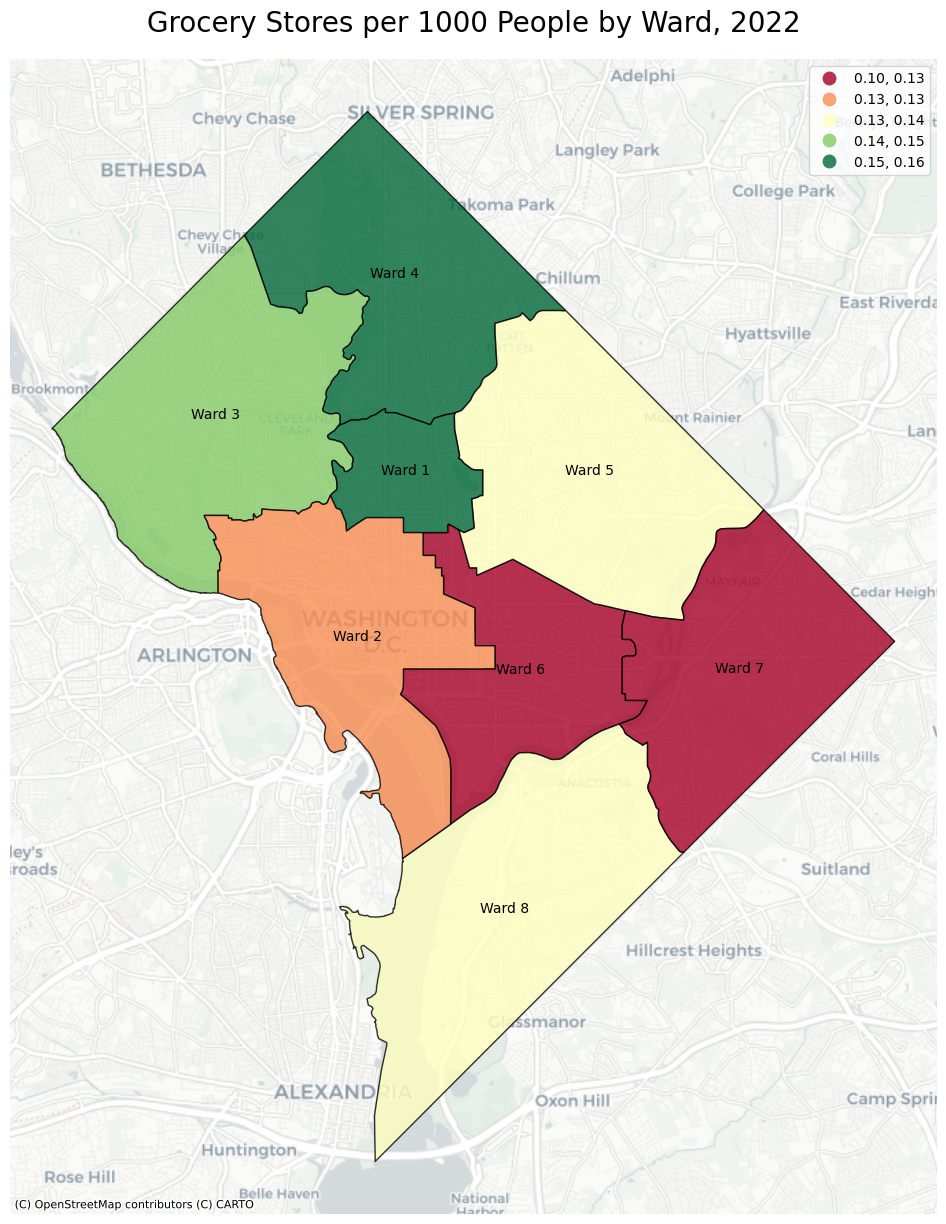

In [36]:
# map entire dataframe with new lag column
# use subplots for multiple layers
fig,ax = plt.subplots(figsize=(15,15))
# spatial lag choropleth
gdf_wards.plot(ax=ax,
               figsize=(15,15),
               column='groceries_per_1000_lag',
               legend=True,
               alpha=0.8,
               cmap='RdYlGn',
               edgecolor='black',
               scheme='quantiles')
gdf_wards.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
ax.axis('off')
ax.set_title('Grocery Stores per 1000 People by Ward, 2022', fontsize=20, pad=20)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The plot above helps better visualize how grocery store data is distributed per 1000 people across each Ward. Dark and light green areas indicate where there is more grocery store locations per 1000 people, orange and yellow indicate a moderate availability, whereas red indicates a lower availability. We can observe that proportionate availability is greater in the northwest Wards and lesser in the southeast Wards. Let's also create an interactive version that will allow us to hover per Ward and get more information about the Ward number, total population within that Ward, grocery store count, and grocery store proportion per 1000 people.
## Moran's Plot 
We now want to calculate the significance, and will start by testing for the global autocorrelation for grocery stores as a continuous data variable. We'll caluclate the Moran I value to find the slope of the "grocery stores per 1000 spatial lag" scatterplot.

In [37]:
# moran's plot to test for global autocorrelation of grocery stores
y = gdf_wards.groceries_per_1000
moran = Moran(y,wq)
moran.I

0.04011408890647716

The 0.154 value represents the slope for the normalized grocery store data. We'll generate a scatterplot using this slope to see how likely the observed correlation is a randomly generated result, before creating a sampling distribution of grocery values randomly distributed across wards.

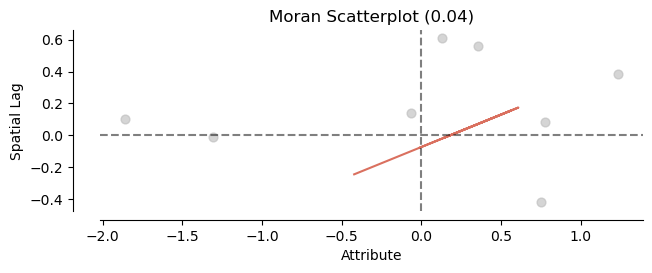

In [38]:
# create a scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.10/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.04', ylabel='Density'>)

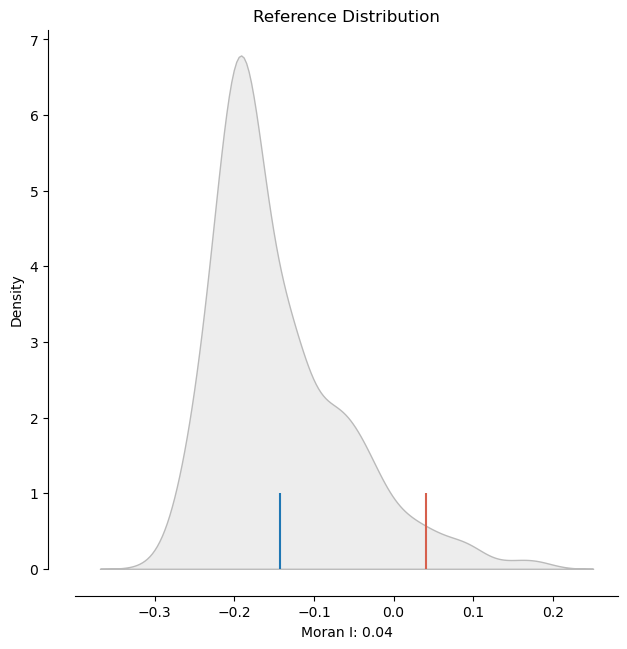

In [39]:
# find significance
plot_moran_simulation(moran,aspect_equal=False)

Now, let's calculate the p-value to determine statistical significance.

In [40]:
# compute p-value
moran.p_sim

0.04

The caluclated p-value is equal to 0.01, which is lower than the generally used p < 0.05 standard, so we should be able to reject the hypothesis that the plot was randomly generated. In other words, we could interpret this to say that there is statistical significance in the relationship between grocery store location placement by Ward.

## Local Spatial Autocorrelation 

Now, we can conduct a local spatial correlation using Local Indicators of Spatial Association (LISA) to identify high near high, low near low, low near high, and high near low geographies. Once we calculate the local Moran values, we can create a local scatterplot.

In [41]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

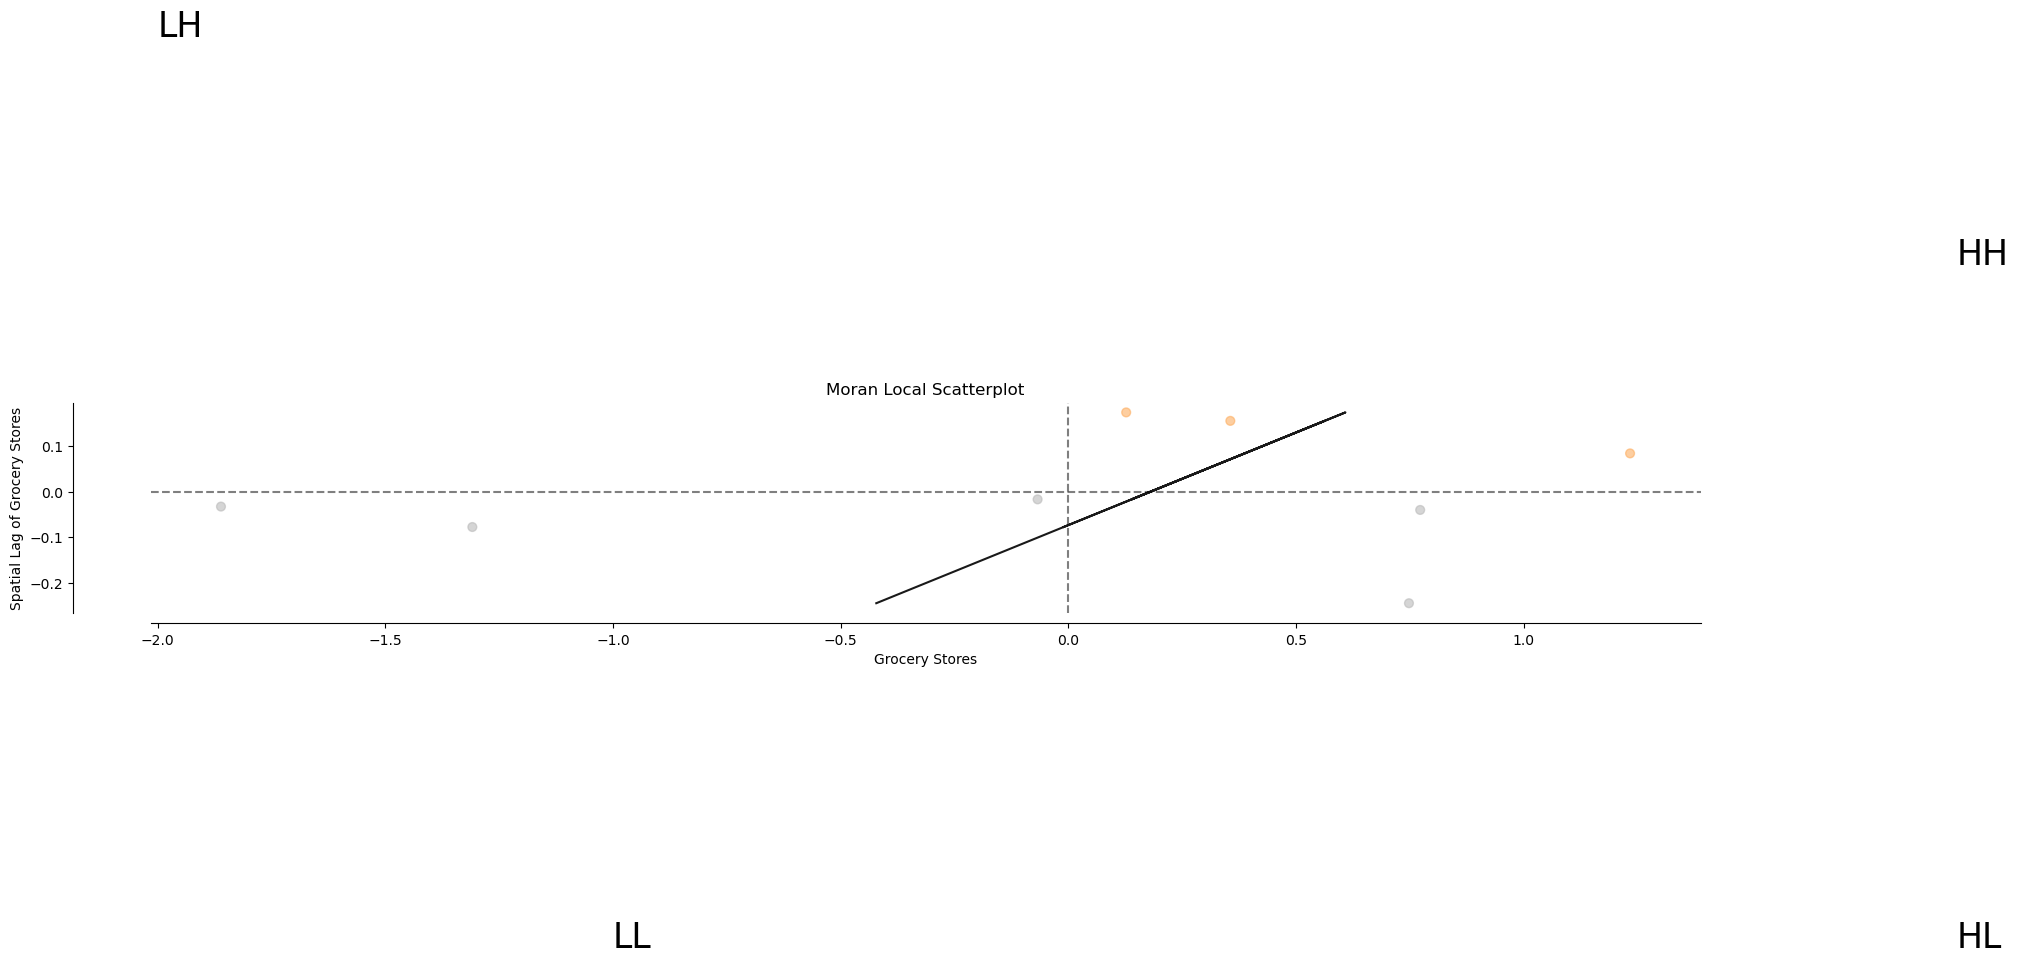

In [42]:
# plot
fig, ax=plt.subplots(figsize=(20,15))
moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Grocery Stores")
ax.set_ylabel('Spatial Lag of Grocery Stores')

plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

This scatterplot tells us the Wards that have a statistically significant p-value. These are going to be the areas with a validated geostatistical relationship.

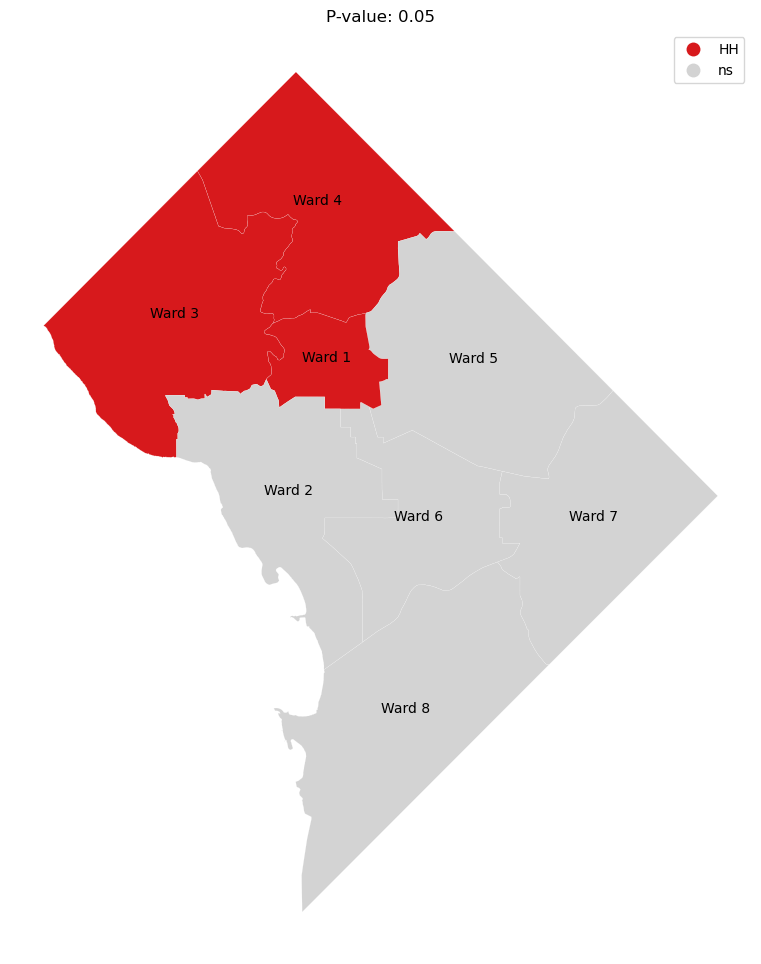

In [43]:
# spatial autocorrelation map
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf_wards, p=0.05, ax=ax)
gdf_wards.apply(lambda x: ax.annotate(text=x['NAME'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
ax.set_title("P-value: 0.05")
plt.show()

When we map the p-value, we can see that statistical significance when p < 0.05 is concentrated in Wards 1, 2, 3, and 4. This indicates that there is a validated relationship between grocery store location and ward placement specifically for Wards 1 - 4, which also happens to be the wards with some of the highest number of grocery stores and proportional grocery store availability. In other words, there seems to be an intentional relationship between grocery store relationship within specific wards. 

# NB Viewer link:
https://nbviewer.org/github/rseiberg/food_access_dc/blob/main/Group%20Assignments/Final%20Project/final/Part%202b%20existing%20food%20landscapes.ipynb